In [ ]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from openai import OpenAI
import os

In [ ]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [81]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

document_content = ""

@tool
def update(content: str) -> str:
    """Updates the document with the provided content."""
    
    global document_content
    document_content = content
    return f"Document content have been updated succesfuly. Current content is \n{document_content}"

@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.
    
    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith(".txt"):
        filename = f"{filename}.txt"

    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        return(f"Document saved in the text file {filename}")
    except Exception as e:
        return f"Error saving file {str(e)}"

tools = [update, save]

In [ ]:
llm = init_chat_model('openai:gpt-4o').bind_tools(tools)

In [83]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{document_content}
    """)

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)
    else:
        user_input = input("\nWhat would you like to do with the document? ") 
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = llm.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}


In [84]:
def should_continue(state: AgentState) -> str:
    """ Determine if we should continue or end the conversation. """

    messages = state["messages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"

def print_messages(messages):
    """ Function I made to print the messages in a more readable format """
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")

In [85]:
graph =  StateGraph(AgentState)

graph.add_node("model", model_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("model")
graph.add_edge("model", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    { "continue": "model",
      "end": END }
)

app = graph.compile()

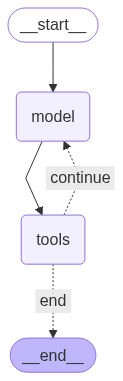

In [86]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [89]:
def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    print(document_content)

In a bustling city lived a meticulous man named Save. His job was to save everything: documents, memories, and even broken dreams. With a trusty backpack of tools, he ventured through life, ensuring nothing valuable was ever lost. Save believed in second chances and the magic of preservation.

One day, he stumbled upon an ancient library, forgotten by time. Its crumbling walls whispered secrets of the past. Save spent days exploring its dusty aisles, rescuing stories from oblivion. In doing so, he discovered his own story, woven into the tapestry of humanity.

Author: Carlos
